# Adults Census Model Training with IBM Watson Studio
## Scikit-learn: Decision Tree Algorithm

This notebook used to experiment Scikit-learn with WML by utilizing the pre-built container.

[Analysis](#compaire)

- **Performance metrics for Local and WML training hardware are similar?.**


## Outline

1. [Data Preparation](#data_prep)
2. [Model Training](#train)
    - 2.1 [Runtime Information](#runtime)
    - 2.2 [Setup](#runtime_setup)
    - 2.3 [Model Training](#model_train)
    - 2.4 [Save model](#save_model)
3. [Model Comparison](#compaire)
4. [IBM Watson Studio](#watson)

<a id="data_prep"></a>
### 1. Data Preparation


In [11]:
# Python libraries that we'll use throughout the analysis
import os
import pandas as pd
import numpy as np
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_ff84544628e941f890b581454b0e5630 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='qOYLX9hHTq5wVFsyqqoueS5Rpvfz2_j08TnpS4qBJKrf',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_ff84544628e941f890b581454b0e5630.get_object(Bucket='mlproject-donotdelete-pr-g6j7hl10bonvf1',Key='adult.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.shape


(45222, 15)

<a id="train"></a>
### 2 Model Training
   - 2.1 [Runtime Information](#runtime)
   - 2.2 [Setup](#runtime_setup)
   - 2.3 [Model Training](#model_train)
   - 2.4 [Save model](#save_model)

<a id="runtime"></a>
##### 2.1 Runtime Information

**The runtime has 1 vCPU and 4 GB RAM.**

<a id="runtime_setup"></a>
###### 2.2 Setup

In [15]:
#! pip install watermark
%reload_ext watermark
%watermark  -d -u -h -m -a "IBM Watson Studio" -v -p numpy,pandas,scipy,sklearn,ibm_boto3,botocore,ibm_watson_machine_learning

Author: IBM Watson Studio

Last updated: 2020-12-16

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.15.0

numpy                      : 1.18.5
pandas                     : 1.0.5
scipy                      : 1.5.0
sklearn                    : 0.23.1
ibm_boto3                  : 2.7.0
botocore                   : 1.16.11
ibm_watson_machine_learning: 1.0.44

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 4.4.0-194-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 56
Architecture: 64bit

Hostname: notebook-conda1py3739bfc4b24a4143d1b5502cd9a51e97ed-85c77fpdjcj



<a id="model_train"></a>
###### 2.3 Model training

In [17]:
# Python libraries 
import time
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

start_time = time.time()

#Prepocessing

print('building datasets')
features = 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country'
target = 'IncomeGroup'
X = df[features.split()]
y = df[target]

# label encode the target variable to have the classes 0 and 1
y = LabelEncoder().fit_transform(y)

cat_ix = X.select_dtypes(include=['object', 'bool']).columns
print(f"cat_ix: {cat_ix}")
num_ix = X.select_dtypes(include=['int64', 'float64']).columns
print(f"num_ix: {num_ix}")

#use stratify for un balanced number of examples for each class label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)
print(f"X_train:{X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train:{y_train.shape}")
print(f"y_test: {y_test.shape}")

# Model Training: DecisionTreeClassifier
print('training model')
MODEL = 'CART'
# define steps
model = DecisionTreeClassifier(max_leaf_nodes=30, random_state=42)
    
steps = [('c',OneHotEncoder(handle_unknown='ignore'),cat_ix), ('n',MinMaxScaler(),num_ix)]
# one hot encode categorical, normalize numerical
ct = ColumnTransformer(steps)
# wrap the model a pipeline
pipe  = Pipeline(steps=[('transformer',ct),('cart',model)])
pipe.fit(X_train, y_train)
print(f"model: {pipe}")
  
## Evaluate the model
# using threshold
threshold = 0.5 # set threshold as 0.5
y_pred = (pipe.predict_proba(X_test)[:,1] >= threshold).astype(int) 
print(f"y_pred: {y_pred}")
print(f'Misclassified examples:{(y_test != y_pred).sum()}')
print(pipe.predict_proba(X_test))
  
print(f"distinct y_pred: {np.unique(y_pred)}")
print(f"distinct y_test: {np.unique(y_test)}")
  
# Confusion Matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")

# AUC
auc = metrics.roc_auc_score(y_test, y_pred)
print(f"auc: {auc}")

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}") 

# Precision
precision = metrics.precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Recall
recall = metrics.recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# F1
f1 = metrics.f1_score(y_test, y_pred)
print(f"F1: {f1}")

# classification_report
print('classification_report')
print(metrics.classification_report(y_test, y_pred))

time_elapsed = (time.time() - start_time)
print("Computational time:{}".format(time_elapsed))

building datasets
cat_ix: Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')
num_ix: Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')
X_train:(31655, 14)
X_test: (13567, 14)
y_train:(31655,)
y_test: (13567,)
training model
model: Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('c',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')),
                                                 ('n', MinMaxScaler(),
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype=

<a id="save_model"></a>
###### 2.4 Save model

In [18]:
from botocore.client import Config
import ibm_boto3

client_ff84544628e941f890b581454b0e5630 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='qOYLX9hHTq5wVFsyqqoueS5Rpvfz2_j08TnpS4qBJKrf',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

# persist model
joblib.dump(pipe, f"{MODEL}.joblib")
client_ff84544628e941f890b581454b0e5630.upload_file(Filename=f"{MODEL}.joblib",
                                                    Bucket='mlproject-donotdelete-pr-g6j7hl10bonvf1',
                                                    Key=f"{MODEL}.joblib")

<a id="compaire"></a>
#### 3. Model Comparison

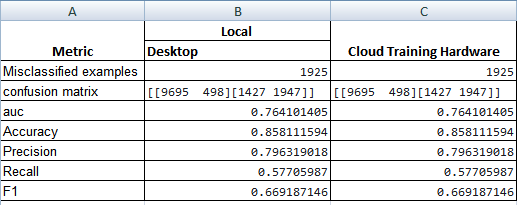

In [1]:
from IPython.display import Image

Image(filename='images/Watson/Exp-2/CART/compare.png')

 <a id="watson"></a>
#### 4. IBM Watson Studio

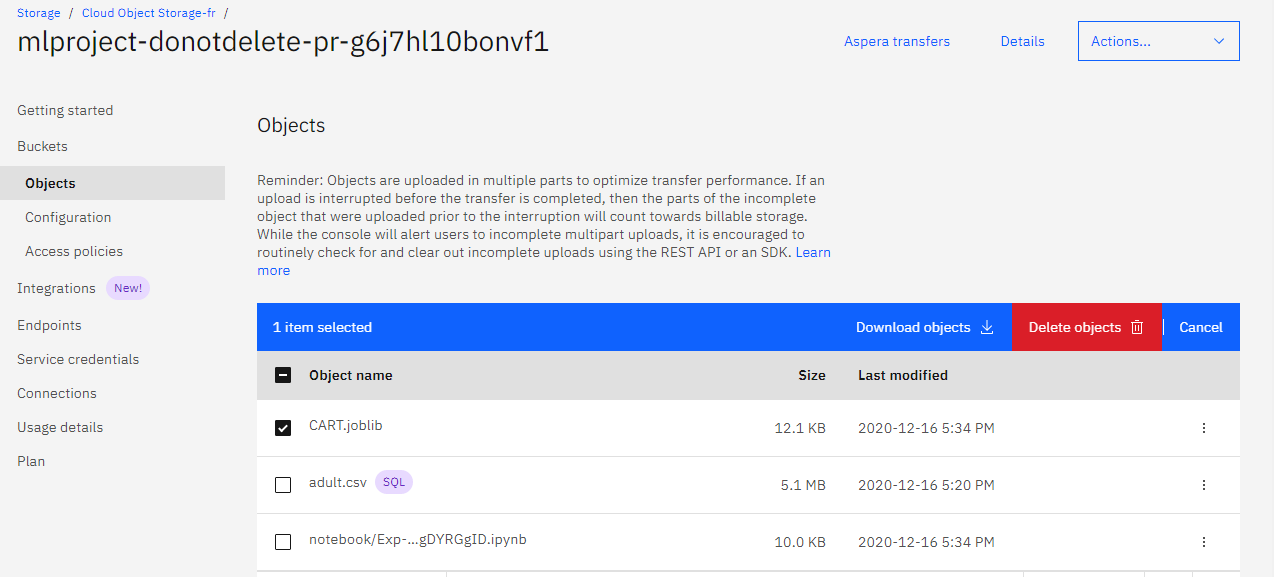

In [2]:

Image(filename='images/Watson/Exp-2/CART/bucket-objects.png')

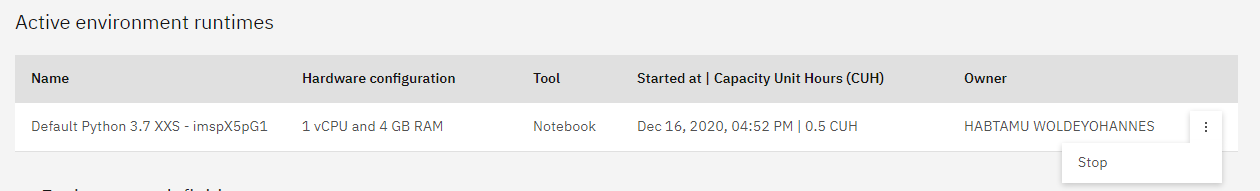

In [3]:
Image(filename='images/Watson/Exp-2/CART/runtime.png')

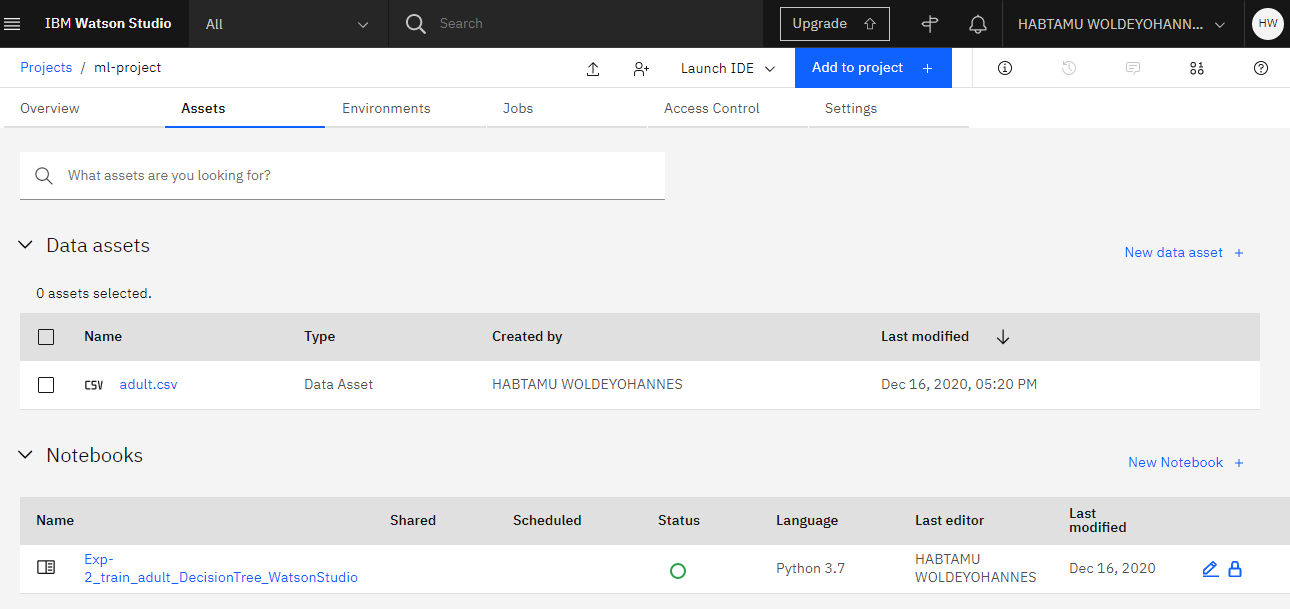

In [4]:
Image(filename='images/Watson/Exp-2/CART/main-page.png')